# Biboliotecas utilizadas

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
import time
from collections import deque
import mediapipe as mp

# Entrenamiento del modelo para la detección de emociones usando fine tuning

In [2]:
class FER2013RGB(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        pixels = np.array(list(map(int, self.data.loc[idx, 'pixels'].split())))
        pixels = pixels.reshape(48, 48).astype(np.uint8)
        pixels = np.stack([pixels]*3, axis=-1)
        label = int(self.data.loc[idx, 'emotion'])
        
        if self.transform:
            pixels = self.transform(pixels)
        
        return pixels, label

In [3]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False
    
    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0
            return True 
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

Usando: cuda
Train: 28709 | Val: 3589


c:\Users\Javier\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/50 | Train Acc: 0.484 | Val Acc: 0.592
✓ Modelo guardado (Val Acc: 0.592)
Epoch 02/50 | Train Acc: 0.586 | Val Acc: 0.624
✓ Modelo guardado (Val Acc: 0.624)
Epoch 03/50 | Train Acc: 0.612 | Val Acc: 0.633
✓ Modelo guardado (Val Acc: 0.633)
Epoch 04/50 | Train Acc: 0.627 | Val Acc: 0.639
✓ Modelo guardado (Val Acc: 0.639)
Epoch 05/50 | Train Acc: 0.645 | Val Acc: 0.664
✓ Modelo guardado (Val Acc: 0.664)
Epoch 06/50 | Train Acc: 0.661 | Val Acc: 0.659
Epoch 07/50 | Train Acc: 0.669 | Val Acc: 0.667
✓ Modelo guardado (Val Acc: 0.667)
Epoch 08/50 | Train Acc: 0.683 | Val Acc: 0.670
✓ Modelo guardado (Val Acc: 0.670)
Epoch 09/50 | Train Acc: 0.693 | Val Acc: 0.668
Epoch 10/50 | Train Acc: 0.706 | Val Acc: 0.676
✓ Modelo guardado (Val Acc: 0.676)
Epoch 11/50 | Train Acc: 0.711 | Val Acc: 0.673
Epoch 12/50 | Train Acc: 0.725 | Val Acc: 0.678
✓ Modelo guardado (Val Acc: 0.678)
Epoch 13/50 | Train Acc: 0.735 | Val Acc: 0.679
Epoch 14/50 | Train Acc: 0.740 | Val Acc: 0.686
✓ Modelo guar

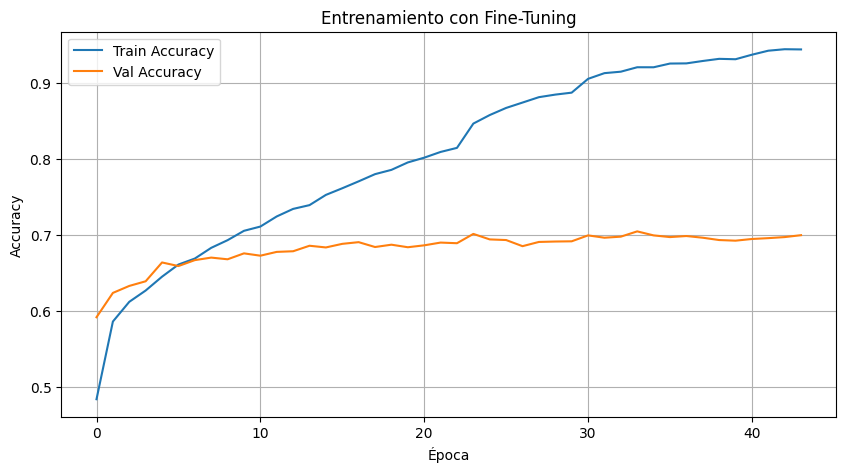


✓ Mejor Val Accuracy: 0.705
✓ Modelo guardado en: best_resnet18_finetuned.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {device}')


BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 10

EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]


train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = FER2013RGB('fer2013.csv', usage='Training', transform=train_transform)
val_dataset = FER2013RGB('fer2013.csv', usage='PublicTest', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(train_dataset)} | Val: {len(val_dataset)}')


model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7)
)

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)


early_stopping = EarlyStopping(patience=PATIENCE)

train_accs, val_accs = [], []
best_val_acc = 0

for epoch in range(1, EPOCHS + 1):

    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    train_acc = train_correct / train_total
    train_accs.append(train_acc)
    

    model.eval()
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_accs.append(val_acc)
    

    scheduler.step(val_acc)
    
    print(f'Epoch {epoch:02d}/{EPOCHS} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    

    if early_stopping(val_acc):
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_finetuned.pth')
        print(f'Modelo guardado (Val Acc: {val_acc:.3f})')
    
    if early_stopping.early_stop:
        print(f'Early stopping activado en época {epoch}')
        break



plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Entrenamiento con Fine-Tuning')
plt.legend()
plt.grid(True)
plt.show()

print(f'\nMejor Val Accuracy: {best_val_acc:.3f}')
print(f'Modelo guardado en: best_resnet18_finetuned.pth')

## Matriz de confusión

Preparando transformaciones...
Cargando dataset de test (PrivateTest)...
Número de muestras en PrivateTest: 3589
DataLoader listo.
Configurando modelo...
Dispositivo utilizado: cuda


c:\Users\asmae\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asmae\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Cargando pesos del modelo entrenado...
Modelo cargado y listo para inferencia.

Comenzando inferencia sobre PrivateTest...


C:\Users\asmae\AppData\Local\Temp\ipykernel_28088\2281054109.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_resnet18_finetuned.pth", map_

Procesando batch 1/57...
Procesando batch 2/57...
Procesando batch 3/57...
Procesando batch 4/57...
Procesando batch 5/57...
Procesando batch 6/57...
Procesando batch 7/57...
Procesando batch 8/57...
Procesando batch 9/57...
Procesando batch 10/57...
  → Avance: 10/57 batches (4.1s)
Procesando batch 11/57...
Procesando batch 12/57...
Procesando batch 13/57...
Procesando batch 14/57...
Procesando batch 15/57...
Procesando batch 16/57...
Procesando batch 17/57...
Procesando batch 18/57...
Procesando batch 19/57...
Procesando batch 20/57...
  → Avance: 20/57 batches (7.6s)
Procesando batch 21/57...
Procesando batch 22/57...
Procesando batch 23/57...
Procesando batch 24/57...
Procesando batch 25/57...
Procesando batch 26/57...
Procesando batch 27/57...
Procesando batch 28/57...
Procesando batch 29/57...
Procesando batch 30/57...
  → Avance: 30/57 batches (10.9s)
Procesando batch 31/57...
Procesando batch 32/57...
Procesando batch 33/57...
Procesando batch 34/57...
Procesando batch 35/57...

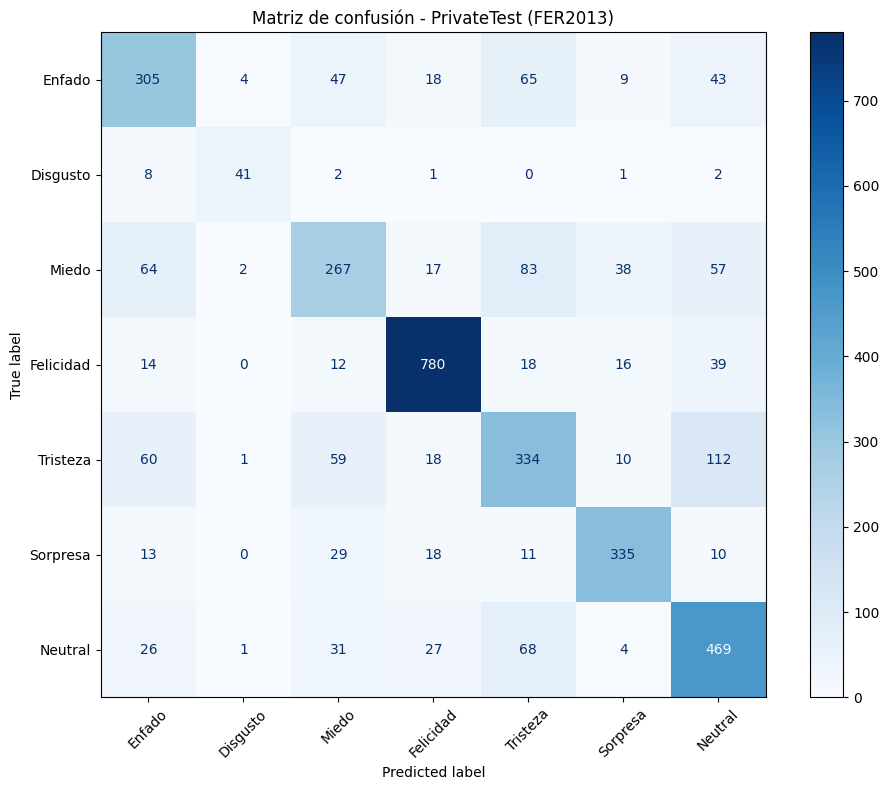

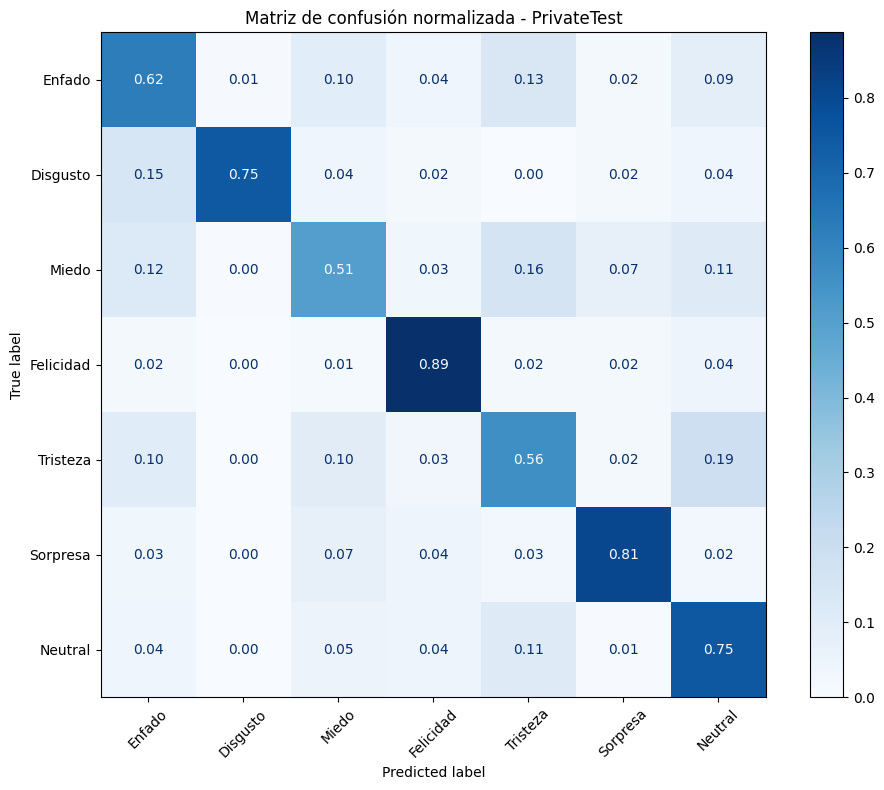


✓ Proceso completado.


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image


print("Preparando transformaciones...")
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


print("Cargando dataset de test (PrivateTest)...")
csv_path = "fer2013.csv"
test_dataset = FER2013RGB(
    csv_path=csv_path,
    usage="PrivateTest",
    transform=val_transform
)

print(f"Número de muestras en PrivateTest: {len(test_dataset)}")
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
print("DataLoader listo.")


print("Configurando modelo...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

model = models.resnet18(pretrained=False)

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7)
)

model = model.to(device)


print("Cargando pesos del modelo entrenado...")
state_dict = torch.load("best_resnet18_finetuned.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Modelo cargado y listo para inferencia.")


print("\nComenzando inferencia sobre PrivateTest...")
all_preds = []
all_labels = []

start_time = time.time()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        print(f"Procesando batch {batch_idx+1}/{len(test_loader)}...")
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        if (batch_idx+1) % 10 == 0 or (batch_idx+1) == len(test_loader):
            elapsed = time.time() - start_time
            print(f"  → Avance: {batch_idx+1}/{len(test_loader)} batches ({elapsed:.1f}s)")

print("\nInferencia terminada.")
total_time = time.time() - start_time
print(f"Tiempo total: {total_time:.2f} segundos")


print("\nConcatenando resultados...")
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"\n**Precisión en PrivateTest: {accuracy*100:.2f}%**")


print("\nCalculando matriz de confusión...")
class_names = ["Enfado", "Disgusto", "Miedo",
               "Felicidad", "Tristeza", "Sorpresa", "Neutral"]

cm = confusion_matrix(all_labels, all_preds)
print("\nMatriz de confusión absoluta:")
print(cm)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("Matriz de confusión - PrivateTest (FER2013)")
plt.tight_layout()
plt.show()

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(10, 8))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp_norm.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45, values_format=".2f")
plt.title("Matriz de confusión normalizada - PrivateTest")
plt.tight_layout()
plt.show()

print("\n✓ Proceso completado.")

# Filtro según la emoción en real time

## Función para dibujar arcoíris y corazones (Happy)

In [ ]:
def draw_happy_effect(frame, x, y, w, h):
    
    center_x = x + w//2
    
    colors = [(0, 0, 255), (0, 127, 255), (0, 255, 255), (0, 255, 0), (255, 255, 0)]
    for i, color in enumerate(colors):
        arc_y = y - 100 + i * 8
        cv2.ellipse(frame, (center_x, arc_y), (w//2 + i*5, 40), 
                   0, 0, 180, color, 6)
    
    for i in range(3):
        heart_x = center_x + (i-1) * 60
        heart_y = y - 150 - i * 20
        cv2.circle(frame, (heart_x - 10, heart_y), 15, (255, 3, 200), -1)
        cv2.circle(frame, (heart_x + 10, heart_y), 15, (255, 3, 200), -1)
        pts = np.array([[heart_x - 25, heart_y], [heart_x, heart_y + 25], 
                       [heart_x + 25, heart_y]], np.int32)
        cv2.fillPoly(frame, [pts], (255, 3, 200))


## Función para dibujar nube, lágrimas y pañuelo (Sad)

In [ ]:
def draw_sad_effect(frame, x, y, w, h):
    
    tissue_x = x - 50
    tissue_y = y + h//2
    
    cv2.rectangle(frame, (tissue_x, tissue_y), 
                 (tissue_x + 40, tissue_y + 50), (240, 240, 255), -1)
    cv2.rectangle(frame, (tissue_x, tissue_y), 
                 (tissue_x + 40, tissue_y + 50), (200, 200, 220), 3)

    for i in range(5):
        cv2.line(frame, (tissue_x + i*8, tissue_y), 
                (tissue_x + i*8, tissue_y + 50), (220, 220, 240), 1)
    
    tear_positions = [(x + w//4, y + h//2 + 10), (x + 3*w//4, y + h//2 + 10)]
    for tx, ty in tear_positions:
        for i in range(4):
            drop_y = ty + i * 25
            drop_size = 8 - i
            cv2.circle(frame, (tx, drop_y), drop_size, (255, 200, 150), -1)
            cv2.circle(frame, (tx, drop_y), drop_size + 2, (200, 150, 100), 2)
    
    cloud_x, cloud_y = x + w//2, y - 80
    cv2.ellipse(frame, (cloud_x, cloud_y), (60, 30), 0, 0, 360, (150, 150, 150), -1)
    cv2.ellipse(frame, (cloud_x - 30, cloud_y + 10), (40, 25), 0, 0, 360, (130, 130, 130), -1)
    cv2.ellipse(frame, (cloud_x + 30, cloud_y + 10), (40, 25), 0, 0, 360, (130, 130, 130), -1)


## Función para dibujar Llamas y cuernos (Angry)

In [ ]:
def draw_angry_effect(frame, x, y, w, h):

    center_x, center_y = x + w//2, y + h//2
    
    horn_left = np.array([
        [x + w//4 - 10, y],
        [x + w//4 - 30, y - 50],
        [x + w//4, y - 10]
    ], np.int32)
    cv2.fillPoly(frame, [horn_left], (0, 0, 180))
    cv2.polylines(frame, [horn_left], True, (0, 0, 255), 3)
    
    horn_right = np.array([
        [x + 3*w//4 + 10, y],
        [x + 3*w//4 + 30, y - 50],
        [x + 3*w//4, y - 10]
    ], np.int32)
    cv2.fillPoly(frame, [horn_right], (0, 0, 180))
    cv2.polylines(frame, [horn_right], True, (0, 0, 255), 3)
    
    num_flames = 16
    for i in range(num_flames):
        angle = (360 / num_flames) * i
        rad = np.radians(angle)
        distance = max(w, h) // 2 + 40
        
        fx = int(center_x + distance * np.cos(rad))
        fy = int(center_y + distance * np.sin(rad))
        
        flame_size = 20 + np.random.randint(-5, 10)
        flame = np.array([
            [fx, fy - flame_size],
            [fx - 8, fy + 5],
            [fx + 8, fy + 5]
        ], np.int32)
        
        color = (0, np.random.randint(100, 200), np.random.randint(200, 255))
        cv2.fillPoly(frame, [flame], color)

## Función para dibujar estrellas y signos de exclamación (Surprise)

In [66]:
def draw_surprise_effect(frame, x, y, w, h):

    center_x, center_y = x + w//2, y + h//2
    
    exclamation_positions = [
        (x - 40, y + h//2),
        (x + w + 40, y + h//2),
        (center_x, y - 100)
    ]
    
    for ex, ey in exclamation_positions:
        cv2.rectangle(frame, (ex - 8, ey - 50), (ex + 8, ey - 10), (0, 255, 255), -1)
        cv2.circle(frame, (ex, ey), 10, (0, 255, 255), -1)
        cv2.rectangle(frame, (ex - 8, ey - 50), (ex + 8, ey - 10), (0, 120, 255), 3)
        cv2.circle(frame, (ex, ey), 10, (0, 120, 255), 3)
    
    for i in range(12):
        angle = (360 / 12) * i
        rad = np.radians(angle)
        distance = 100 + np.random.randint(-20, 20)
        
        sx = int(center_x + distance * np.cos(rad))
        sy = int(center_y + distance * np.sin(rad))
        
        cv2.drawMarker(frame, (sx, sy), (255, 255, 0), 
                      cv2.MARKER_STAR, 20, 3)

## Función para dibujar Fantasmas (Fear)

In [63]:
def draw_fear_effect(frame, x, y, w, h):
    
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, 0), (frame.shape[1], frame.shape[0]), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)
    
    ghost_positions = [(x - 80, y + h//2), (x + w + 80, y + h//2)]
    
    for gx, gy in ghost_positions:
        #cv2.ellipse(frame, (gx, gy - 30), (35, 45), 0, 0, 180, (200, 200, 255), -1)
        cv2.ellipse(frame, (gx, gy - 30), (35, 45), 180, 0, 180, (255,255,255), -1)
        cv2.rectangle(frame, (gx - 35, gy - 30), (gx + 35, gy + 20), (255,255,255), -1)
        
        for i in range(5):
            wave_x = gx - 30 + i * 15
            cv2.circle(frame, (wave_x, gy + 20), 8, (255,255,255), -1)
        
        cv2.circle(frame, (gx - 12, gy - 35), 8, (0, 0, 0), -1)
        cv2.circle(frame, (gx + 12, gy - 35), 8, (0, 0, 0), -1)
        
        cv2.circle(frame, (gx, gy - 15), 10, (0, 0, 0), -1)
        
        cv2.circle(frame, (gx - 12, gy - 35), 3, (255, 255, 255), -1)
        cv2.circle(frame, (gx + 12, gy - 35), 3, (255, 255, 255), -1)


## Función para dibujar Olor verde y moscas (Disgust)

In [ ]:

def draw_disgust_effect(frame, x, y, w, h):
    center_x, center_y = x + w//2, y + h//2
    
    for i in range(5):
        smell_x = center_x + (i - 2) * 25
        smell_y = y - 50
        
        points = []
        for j in range(6):
            wave_offset = 10 * math.sin(j * 0.8)
            points.append([int(smell_x + wave_offset), smell_y - j * 20])
        
        pts = np.array(points, np.int32)
        cv2.polylines(frame, [pts], False, (0, 255, 100), 4)
    
    cv2.ellipse(frame, (center_x, y - 120), (50, 30), 0, 0, 360, (0, 200, 50), -1)
    cv2.ellipse(frame, (center_x - 25, y - 100), (35, 25), 0, 0, 360, (0, 180, 40), -1)
    cv2.ellipse(frame, (center_x + 25, y - 100), (35, 25), 0, 0, 360, (0, 180, 40), -1)
    
    import time
    for i in range(4):
        offset_x = 40 * math.sin(time.time() * 3 + i)
        offset_y = 30 * math.cos(time.time() * 4 + i)
        
        fly_x = int(center_x + offset_x + (i - 2) * 30)
        fly_y = int(center_y + offset_y - 50)
        
        cv2.circle(frame, (fly_x, fly_y), 5, (0, 0, 0), -1)
        cv2.ellipse(frame, (fly_x - 4, fly_y - 3), (8, 4), 45, 0, 360, (150, 150, 150), 1)
        cv2.ellipse(frame, (fly_x + 4, fly_y - 3), (8, 4), -45, 0, 360, (150, 150, 150), 1)

## Función para dibujar circulos de meditación (Neutral)

In [ ]:
def draw_neutral_effect(frame, x, y, w, h):
    center_x, center_y = x + w//2, y + h//2
    
    for i in range(4):
        radius = 70 + i * 25
        alpha = 1 - (i / 4)
        thickness = max(1, int(3 * alpha))
        cv2.circle(frame, (center_x, center_y), radius, (200, 180, 150), thickness)
    
    om_x, om_y = center_x, y - 80
    
    cv2.putText(frame, "OM", (om_x - 30, om_y),
               cv2.FONT_HERSHEY_SIMPLEX, 1.5, (180, 160, 140), 3)
    
    for i in range(3):
        leaf_x = center_x + (i - 1) * 50
        leaf_y = y - 120 + i * 15
        
        leaf = np.array([
            [leaf_x, leaf_y - 10],
            [leaf_x - 8, leaf_y + 5],
            [leaf_x, leaf_y],
            [leaf_x + 8, leaf_y + 5]
        ], np.int32)
        cv2.fillPoly(frame, [leaf], (100, 180, 100))
        cv2.polylines(frame, [leaf], True, (80, 150, 80), 2)

## Ejecución del primer prototipo

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]


model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 7)
)

model.load_state_dict(torch.load('best_resnet18_finetuned.pth', map_location=device))
model.eval()
model.to(device)

print("\nLoaded Model Successfuly")


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


EFFECT_FUNCTIONS = {
    "Happy": draw_happy_effect,
    "Sad": draw_sad_effect,
    "Angry": draw_angry_effect,
    "Surprise": draw_surprise_effect,
    "Fear": draw_fear_effect,
    "Disgust": draw_disgust_effect#,
    #"Neutral": draw_neutral_effect
}


cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Couldn't open the camara")
    exit()

print("\nEmotion Detector Effects:")
print("\nControl: 'ESC' quit | 's' screenshot\n")

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100)
    )
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        
        face_img = frame[y:y+h, x:x+w]
        face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        face_tensor = preprocess(face_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(face_tensor)
            probas = torch.softmax(outputs, dim=1)
            pred_idx = probas.argmax(dim=1).item()
            confidence = probas[0, pred_idx].item()
        
        emotion = EMOTIONS[pred_idx]
        

        effect_func = EFFECT_FUNCTIONS.get(emotion)
        if effect_func:
            effect_func(frame, x, y, w, h)
        

        cv2.putText(frame, f"{emotion} ({confidence:.0%})", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200, 50, 255), 2)
    
    cv2.imshow('Emotion Detector', frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break
    elif key == ord('s'):
        cv2.imwrite(f'captura_{frame_count}.jpg', frame)
        print(f"Screenshot saved")
        frame_count += 1


cap.release()
cv2.destroyAllWindows()
print("Finished")


Usando: cuda


C:\Users\asmae\AppData\Local\Temp\ipykernel_20184\2654782076.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_finetuned.p


Loaded Model Successfuly

Emotion Detector Effects:

Control: 'ESC' quit | 's' screenshot

Finished


# Libre

## Clase de métricas

In [57]:
class AttentionMetrics:
    def __init__(self):
        self.blinks = 0
        self.total_time = 0
        self.last_blink_time = 0
        self.attention_history = deque(maxlen=100)
        self.start_time = time.time()
    
    def update_attention(self, is_attentive):
        self.attention_history.append(1 if is_attentive else 0)
        self.total_time = time.time() - self.start_time
    
    def get_attention_percentage(self):
        if len(self.attention_history) == 0:
            return 100
        return int(sum(self.attention_history) / len(self.attention_history) * 100)
    
    def get_blinks_per_minute(self):
        if self.total_time < 1:
            return 0
        return int(self.blinks / (self.total_time / 60))

## Función para calcular aspect ratio de ojos

In [14]:
def calculate_eye_aspect_ratio(landmarks, eye_indices):
    A = np.linalg.norm(landmarks[eye_indices[1]] - landmarks[eye_indices[5]])
    B = np.linalg.norm(landmarks[eye_indices[2]] - landmarks[eye_indices[4]])
    C = np.linalg.norm(landmarks[eye_indices[0]] - landmarks[eye_indices[3]])
    ear = (A + B) / (2.0 * C)
    return ear

## Función para determinar si se está mirando a cámara

In [15]:
def is_looking_at_camera(landmarks):
    nose_tip = landmarks[1]
    left_eye = landmarks[33]
    right_eye = landmarks[263]
    eye_center = (left_eye + right_eye) / 2
    horizontal_deviation = abs(nose_tip[0] - eye_center[0])
    return horizontal_deviation < 0.03

## Función para dibujar el dashboard

In [16]:
def draw_dashboard(frame, attention_percent, is_attentive, metrics):
    h, w = frame.shape[:2]
    
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, 0), (w, 150), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    
    cv2.putText(frame, "ATTENTION AND CONCENTRATION METER",
               (w//2 - 350, 35), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 255, 255), 2)
    
    status_text = "FOCUSED" if is_attentive else "DISTRACTED"
    status_color = (0, 255, 0) if is_attentive else (0, 0, 255)
    cv2.putText(frame, f"Status: {status_text}",
               (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, status_color, 2)
    
    cv2.putText(frame, f"Attention: {attention_percent}%",
               (20, 115), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    bar_width = int(300 * (attention_percent / 100))
    cv2.rectangle(frame, (300, 90), (600, 125), (100, 100, 100), -1)
    cv2.rectangle(frame, (300, 90), (300 + bar_width, 125), status_color, -1)
    cv2.rectangle(frame, (300, 90), (600, 125), (255, 255, 255), 2)
    
    bpm = metrics.get_blinks_per_minute()
    cv2.putText(frame, f"Blinks/min: {bpm}",
               (650, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    minutes = int(metrics.total_time // 60)
    seconds = int(metrics.total_time % 60)
    cv2.putText(frame, f"Time: {minutes:02d}:{seconds:02d}",
               (w - 200, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    cv2.rectangle(overlay, (w - 250, 150), (w, h), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    
    y_offset = 200
    
    looking = is_attentive and is_looking_at_camera
    look_color = (0, 255, 0) if looking else (0, 0, 255)
    cv2.circle(frame, (w - 220, y_offset), 15, look_color, -1)
    cv2.putText(frame, "Looking", (w - 190, y_offset + 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    y_offset += 60
    
    blink_color = (255, 255, 0)
    cv2.circle(frame, (w - 220, y_offset), 15, blink_color, -1)
    cv2.putText(frame, f"Blinks: {metrics.blinks}", (w - 190, y_offset + 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    y_offset = h - 150
    cv2.putText(frame, "TIPS:", (w - 230, y_offset),
               cv2.FONT_HERSHEY_DUPLEX, 0.6, (0, 255, 255), 1)
    
    y_offset += 30
    if bpm > 30:
        cv2.putText(frame, "Rest your eyes", (w - 230, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 200, 100), 1)


## Ejecución del segundo prototipo

In [71]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

BLINK_THRESHOLD = 0.2
BLINK_COOLDOWN = 0.3

metrics = AttentionMetrics()

LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera")
    exit()

print("\nATTENTION AND CONCENTRATION METER\n")
print("\nControls: 'ESC' exit | 'r' reset metrics\n")

is_blinking = False

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = face_mesh.process(rgb_frame)
        
        is_attentive = False
        current_time = time.time()
        
        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            
            h, w, _ = frame.shape
            landmarks = np.array([(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark])
            
            left_ear = calculate_eye_aspect_ratio(landmarks, LEFT_EYE)
            right_ear = calculate_eye_aspect_ratio(landmarks, RIGHT_EYE)
            avg_ear = (left_ear + right_ear) / 2.0
            
            if avg_ear < BLINK_THRESHOLD:
                if not is_blinking and (current_time - metrics.last_blink_time) > BLINK_COOLDOWN:
                    metrics.blinks += 1
                    metrics.last_blink_time = current_time
                    is_blinking = True
            else:
                is_blinking = False
            
            looking_at_camera = is_looking_at_camera(landmarks)
            
            if looking_at_camera:
                is_attentive = True
        
        metrics.update_attention(is_attentive)
        attention_percent = metrics.get_attention_percentage()
        
        draw_dashboard(frame, attention_percent, is_attentive, metrics)
        
        cv2.putText(frame, "Press 'ESC' to exit | 'R' to reset",
                   (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        cv2.imshow('Attention Meter', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break
        elif key == ord('r'):
            metrics = AttentionMetrics()
            print("Metrics reset")

cap.release()
cv2.destroyAllWindows()
print("\nSession finished")
print(f"Summary:")
print(f"  - Average attention: {metrics.get_attention_percentage()}%")
print(f"  - Total blinks: {metrics.blinks}")
print(f"  - Blinks/minute: {metrics.get_blinks_per_minute()}")


ATTENTION AND CONCENTRATION METER


Controls: 'ESC' exit | 'r' reset metrics

Metrics reset

Session finished
Summary:
  - Average attention: 0%
  - Total blinks: 4
  - Blinks/minute: 38
